![](https://www.teslarati.com/wp-content/uploads/2018/09/BFR-2018-spaceship-and-booster-sep-SpaceX-1c.jpg)

# Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import set_config
%matplotlib inline
plt.figure(figsize=(20,15))
set_config(display='diagram')
sns.set_style('darkgrid')
pd.set_option('display.max_columns',0)
pd.set_option('display.max_rows',100)
warnings.filterwarnings('ignore')

<Figure size 1440x1080 with 0 Axes>

In [2]:
spaceship = pd.read_csv('../input/spaceship-titanic/train.csv')
spaceship_test = pd.read_csv('../input/spaceship-titanic/test.csv')
spaceship.shape, spaceship_test.shape
spaceship_train = spaceship.copy()

In [3]:
spaceship.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7851,8379_01,Earth,False,F/1609/S,TRAPPIST-1e,24.0,False,462.0,0.0,0.0,0.0,240.0,Toniel Heney,False
3442,3710_01,Earth,False,G/601/P,55 Cancri e,35.0,False,432.0,0.0,377.0,0.0,0.0,Brie Loverceson,False
5012,5354_02,Mars,False,E/339/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Bares Kraie,False
2494,2677_01,Europa,False,D/90/S,TRAPPIST-1e,51.0,False,0.0,302.0,0.0,1367.0,669.0,Eleon Scerodbox,False
3389,3645_03,Mars,True,D/124/P,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Oats Pepie,True
7537,8057_02,Europa,True,B/267/P,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,Algor Sersocatic,True
8412,8988_06,Earth,True,G/1448/S,TRAPPIST-1e,17.0,False,NaN,0.0,0.0,0.0,0.0,Caseye Fowlesterez,True
1303,1384_02,Earth,True,G/210/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Berty Mayods,False
2337,2518_01,Europa,True,C/87/P,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Minon Fouseding,True
7113,7583_01,Mars,False,F/1574/P,TRAPPIST-1e,36.0,False,32.0,355.0,1826.0,9.0,0.0,Pebuts Pert,True


# Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Text(0.5, 1.0, 'count missing values')

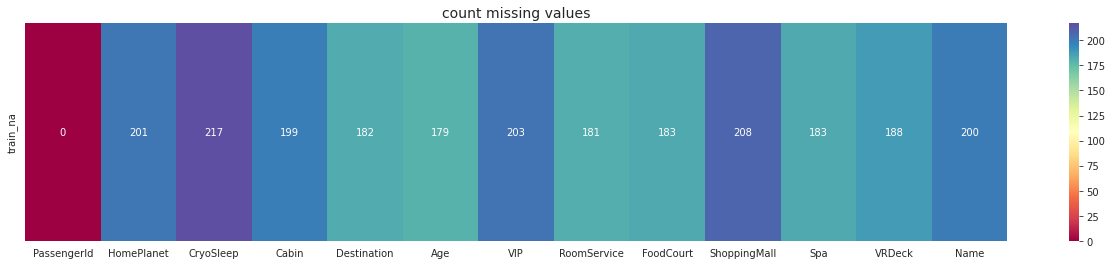

In [4]:
spaceship.info()
plt.figure(figsize=(22,4))
sns.heatmap((spaceship.drop(columns='Transported').isna().sum()).to_frame(name='train_na').T,cmap='Spectral', 
            annot=True, fmt='0.0f').set_title('count missing values', fontsize=14)

In [5]:
spaceship.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


> **It seems almost 200 records are null values in each feature**
>
> **Features (HomePlanet, CryoSleep, Destination and VIP are categories (will convert their types later)**
>
> **Name is not a valuable feature, it doesn't contain any useful information, and some are duplicated as just a coincidence, not a record duplication**
>
> **Service bills have almost 200 null values for each, have we delete or impute by zero or impute by mean (let's check for the better solution)**
>
> **Features (PassengerId, Cabin) have a hidden information inside, we must extract them**

## Extrack known information from (PassengerId, Cabin) before removing them
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [6]:
# Let's create a functions for extracting known information and to use it next in the pipeline
def SplitGroupCabin(df):
    df['passengerGroup'] = df.PassengerId.str.split('_').str[0] 
    df['cabinDeck'] = df.Cabin.str.split('/').str[0]
    df['cabinNum']  = df.Cabin.str.split('/').str[1]
    df['cabinSide'] = df.Cabin.str.split('/').str[2]
    df.drop(columns=['PassengerId','Name','Cabin'], axis = 1, inplace=True)
    return df

SplitGroupCabin(spaceship)
spaceship.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passengerGroup,cabinDeck,cabinNum,cabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,1,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8492 non-null   object 
 1   CryoSleep       8476 non-null   object 
 2   Destination     8511 non-null   object 
 3   Age             8514 non-null   float64
 4   VIP             8490 non-null   object 
 5   RoomService     8512 non-null   float64
 6   FoodCourt       8510 non-null   float64
 7   ShoppingMall    8485 non-null   float64
 8   Spa             8510 non-null   float64
 9   VRDeck          8505 non-null   float64
 10  Transported     8693 non-null   bool   
 11  passengerGroup  8693 non-null   object 
 12  cabinDeck       8494 non-null   object 
 13  cabinNum        8494 non-null   object 
 14  cabinSide       8494 non-null   object 
dtypes: bool(1), float64(6), object(8)
memory usage: 959.4+ KB


Text(0.5, 1.0, 'count missing values')

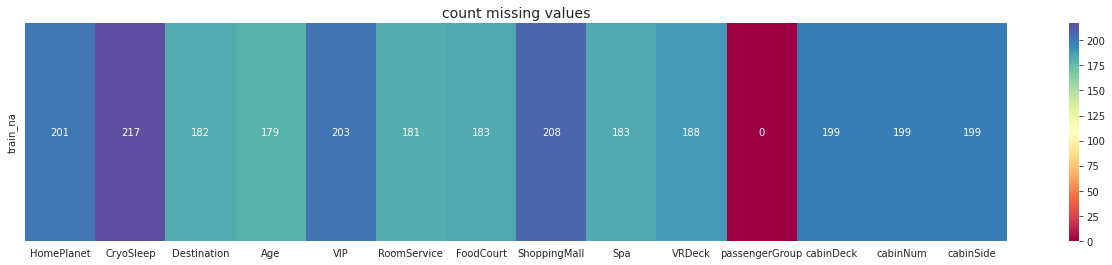

In [7]:
spaceship.info()
plt.figure(figsize=(22,4))
sns.heatmap((spaceship.drop(columns='Transported').isna().sum()).to_frame(name='train_na').T,cmap='Spectral', 
            annot=True, fmt='0.0f').set_title('count missing values', fontsize=14)

In [8]:
# Now, let's make another function to convert features to proper datatypes
cat_col = []
num_col = []
def convert_types(df):
    global cat_col , num_col
    cat_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabinDeck', 'cabinSide']
    num_col = ['Age', 'passengerGroup','cabinNum', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for i in cat_col:
        df[i] = df[i].astype('category')
    for i in (num_col):
        df[i] = df[i].astype('float')
    return df
        

convert_types(spaceship)
spaceship.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passengerGroup,cabinDeck,cabinNum,cabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,F,1.0,S


## Exploring Categorical Features (Homeplanet, CryoSleep, Destination, VIP, cabinDeck, cabinSide)

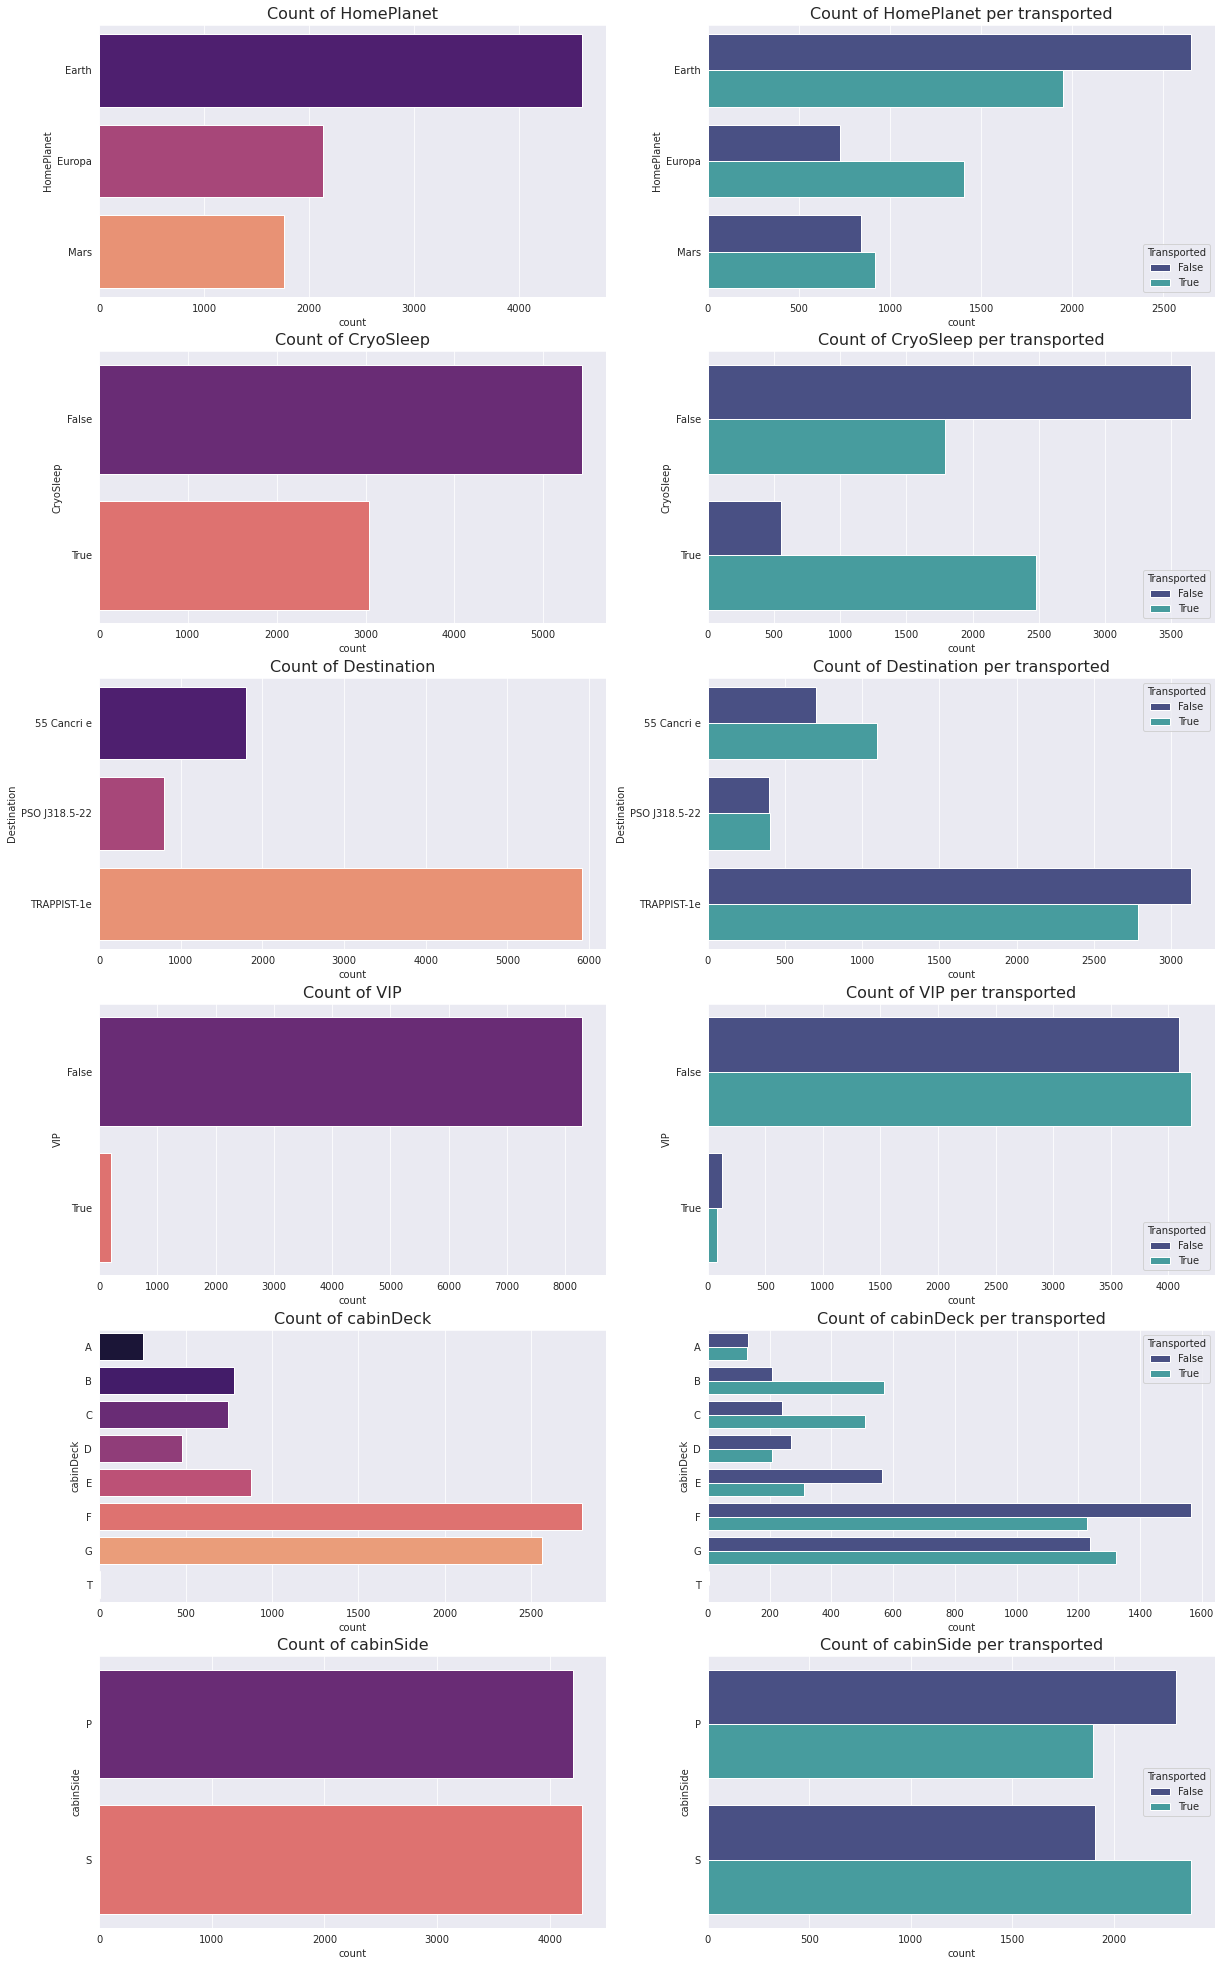

In [9]:
fig, axes = plt.subplots(6,2, figsize=(20,35))
idx = 0
for col in cat_col:
    sns.countplot(data=spaceship, y=col, palette='magma', orient='h',
                  ax=axes[idx][0]).set_title(f'Count of {col}', fontsize='16')
    sns.countplot(data=spaceship, y=col, palette='mako', orient='h',  hue='Transported',
                  ax=axes[idx][1]).set_title(f'Count of {col} per transported', fontsize='16')
    idx +=1
plt.show()

> **Earthers are most likely un-transported, while Europeans are most likely transported, and Marsers are almost split 50/50**
>
> **Those who cryoslepted are often transported, otherwise the non cryoslepted are often un-transported**
>
> **Those in cabin B & C has the better chance to be transported**
>
> **Who lived in side S cabin has better chance to be transported**
>
> **Oh, about the outliers, will use the most frequent value**

## Exploring numerical Features (Age, passengerGroup, cabinNum, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

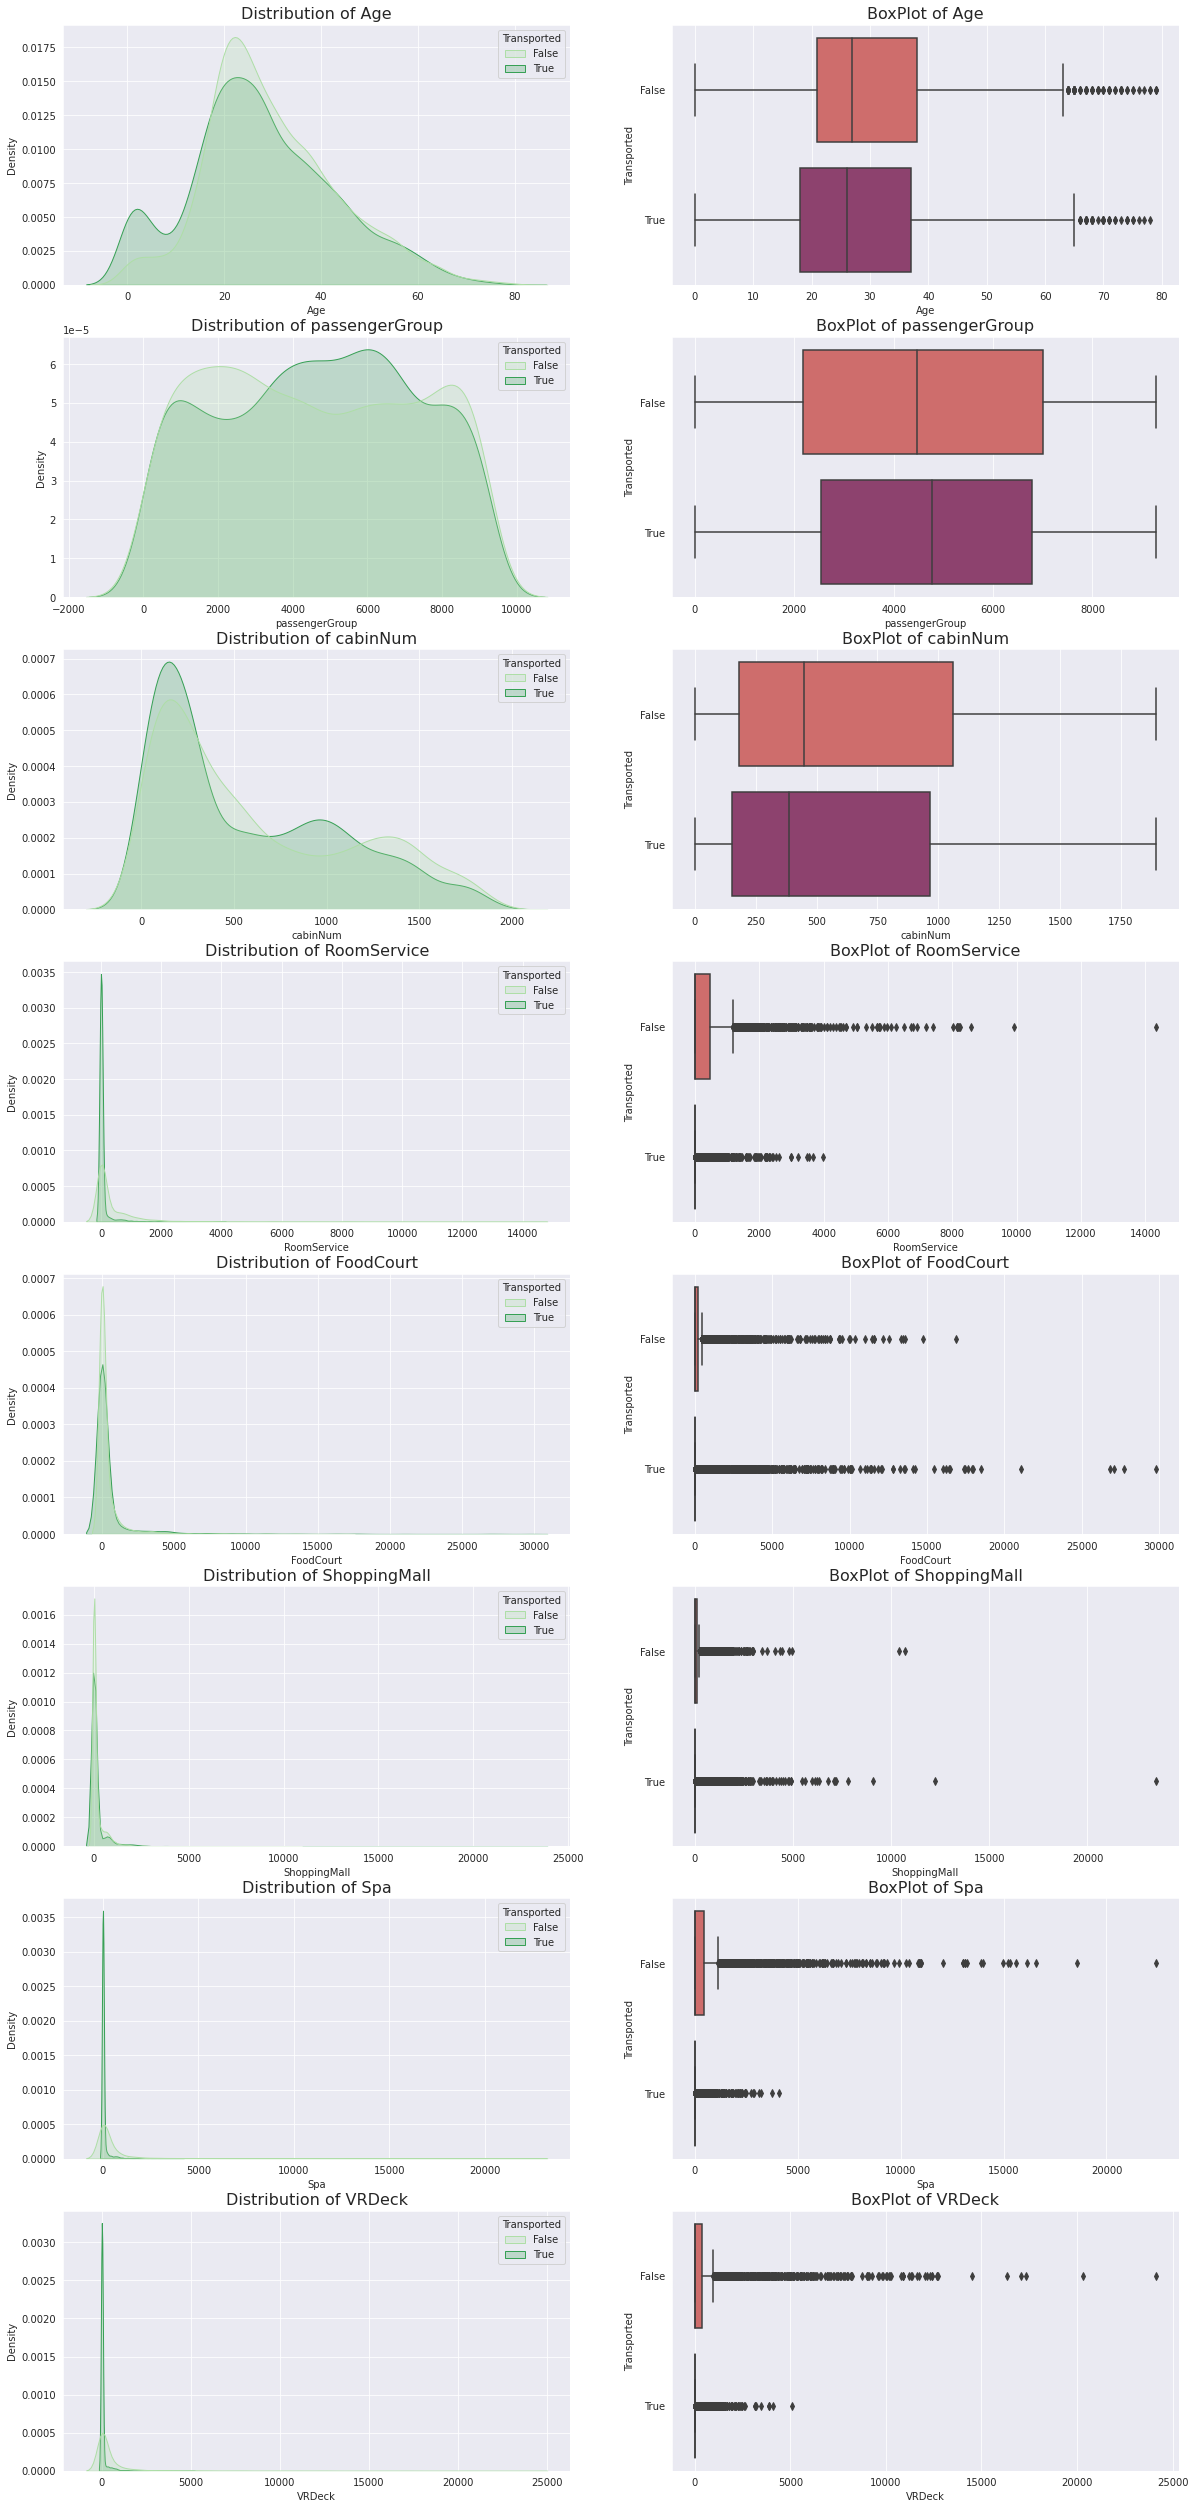

In [10]:
fig, axes = plt.subplots(8,2, figsize=(20,45))
idx = 0
for col in (num_col):
    sns.kdeplot(data=spaceship, x=col, palette='Greens',fill=True , hue='Transported', 
                ax=axes[idx][0]).set_title(f'Distribution of {col}', fontsize='16')
    sns.boxplot(data=spaceship, x=col, palette='flare' , y='Transported', orient='h', 
                ax=axes[idx][1]).set_title(f'BoxPlot of {col}', fontsize='16')
    idx +=1
plt.show()

> **Ok, Age didn't effect any thing, it doesn't matter in transported status (and there is some zero ages, may be they are babies), so we can fill nulls with the mean of ages**
>
> **Same thing with the groups, it didn't effect in transported status, so we can fill nulls with the median (cause it is suposed to be categorical not realy numerical)**
>
> **All other numeric features (the cost of services) full of outliers and most of passengers didn't pay for any thing, so the most common value is Zero, so, the best value to fill in nulls is zero, then we can add them together in one value (Service_val), and count number of services may be it is useful (Service_count)**

# Null Values

In [11]:
from sklearn.impute import SimpleImputer
impute_cols1 = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabinDeck','cabinSide']
impute_cols2 = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
impute_cols3 = ['Age','cabinNum']

imputer1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(spaceship[impute_cols1])
imputer2 = SimpleImputer(missing_values=np.nan, fill_value=0).fit(spaceship[impute_cols2])
imputer3 = SimpleImputer(missing_values=np.nan, strategy='mean').fit(spaceship[impute_cols3])


spaceship[impute_cols1] = imputer1.transform(spaceship[impute_cols1])
spaceship[impute_cols2] = imputer2.transform(spaceship[impute_cols2])
spaceship[impute_cols3] = imputer3.transform(spaceship[impute_cols3])

In [12]:
# create function for calculating sum of all services
def CalculateServices(df):
    service_col = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    df['Service_val'] = 0
    for col in service_col:
        df['Service_val'] += df[col]
    df['Service_count'] = (df[service_col]>0).T.sum().T
    return df
 
CalculateServices(spaceship)
spaceship.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passengerGroup,cabinDeck,cabinNum,cabinSide,Service_val,Service_count
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,B,0.0,P,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,F,0.0,S,736.0,5
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,A,0.0,S,10383.0,4
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,A,0.0,S,5176.0,4
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,F,1.0,S,1091.0,5


# Insights & Visualizations

## Let's see some relations between Features

<AxesSubplot:xlabel='Service_val', ylabel='Transported'>

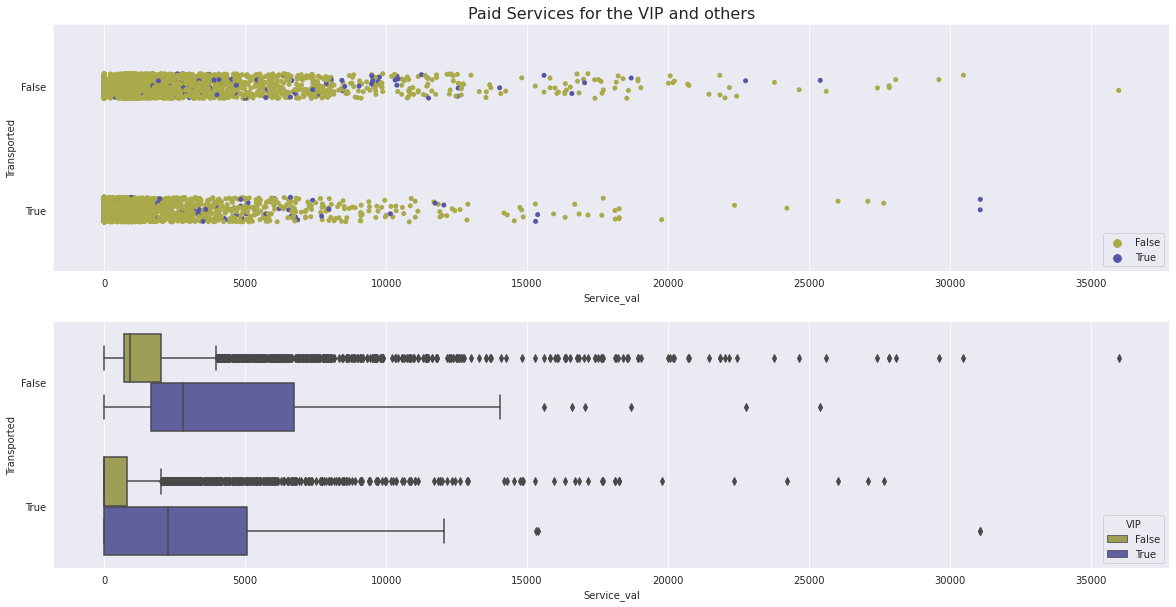

In [13]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
sns.stripplot(data=spaceship, x='Service_val', palette='gist_stern_r', hue='VIP', y='Transported', orient='h', ax=axes[0])
axes[0].set_title('Paid Services for the VIP and others', fontsize='16')
axes[0].legend(loc=4)
sns.boxplot(data=spaceship, x='Service_val', palette='gist_stern_r', hue='VIP', y='Transported', orient='h', ax=axes[1])

> **Impressive, those who didn't transported, paid for services more than others**
>
> **Even the VIP's didn't pay more than others, and don't have more luck in transportation process**

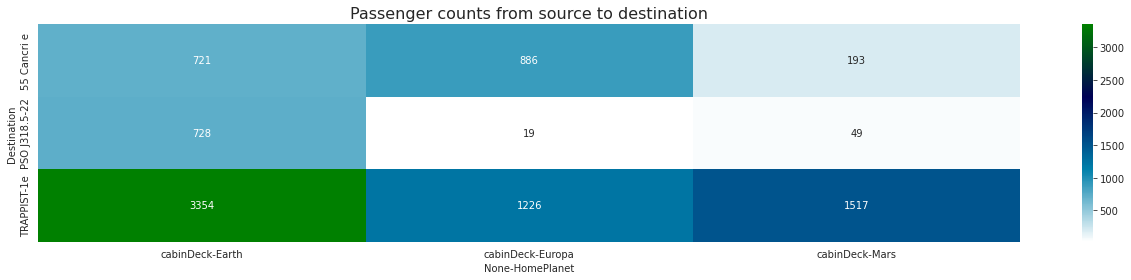

In [14]:
plt.figure(figsize=(22,4))
home_distination = pd.pivot_table(data=spaceship, columns=['HomePlanet'], index=['Destination'], values=['cabinDeck'], aggfunc='count')
sns.heatmap(home_distination,cmap='ocean_r', annot=True, fmt='.4g').set_title('Passenger counts from source to destination', fontsize=16)
plt.show()

> **Most passengers are from Earth going to Trappist, while very little numbers going to other planets**

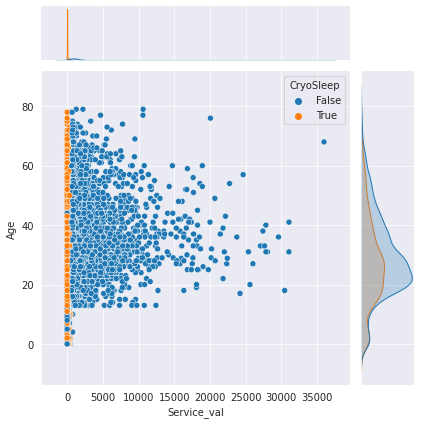

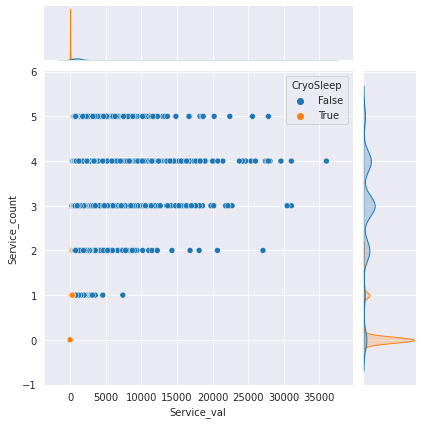

In [15]:
sns.jointplot(data=spaceship, x='Service_val', y='Age', hue='CryoSleep')
sns.jointplot(data=spaceship, x='Service_val', y='Service_count', hue='CryoSleep')
plt.show()

> **Almost all passengers do not take any service, especially the cryosleepers. Otherwise, young people clearly pay more than old people.**

Text(0.5, 1.0, 'Cabin Services by VIP status')

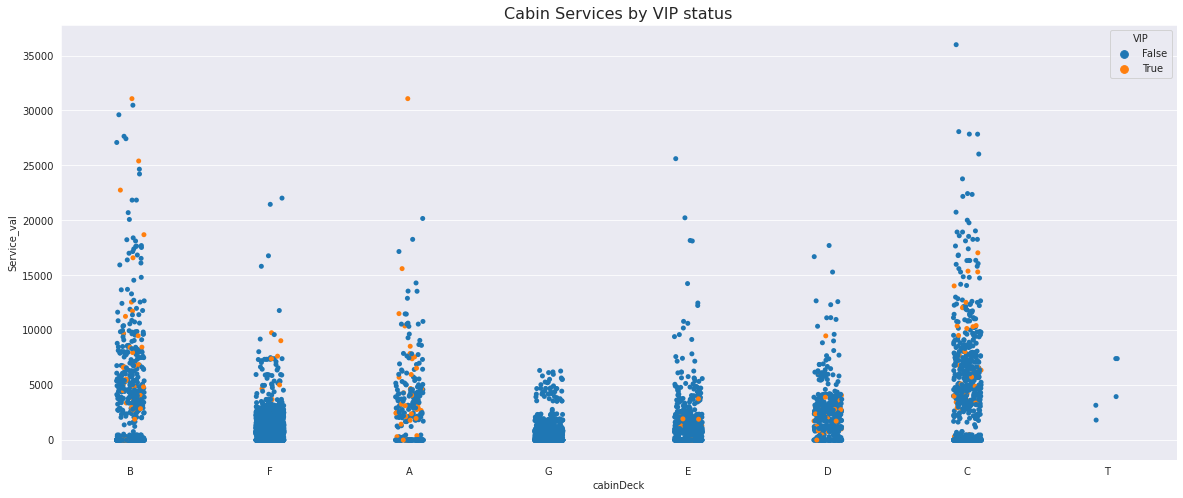

In [16]:
plt.figure(figsize=(20,8))
sns.stripplot(data=spaceship, x='cabinDeck', y='Service_val', hue='VIP' ).set_title('Cabin Services by VIP status', fontsize=16)

> **VIP's count is very less as we know almost (2%) of total count, and they were distributed in all cabins except (G,T)**

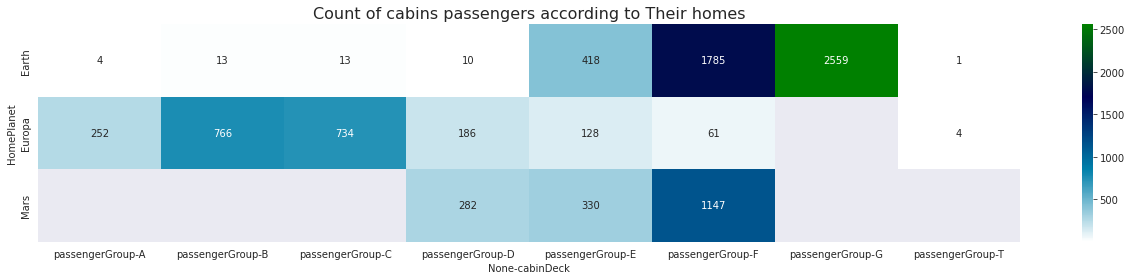

In [17]:
plt.figure(figsize=(22,4))
home_distination = pd.pivot_table(data=spaceship, columns=['cabinDeck'], index=['HomePlanet'], values=['passengerGroup'], aggfunc='count')
sns.heatmap(home_distination,cmap='ocean_r', annot=True, fmt='.4g').set_title('Count of cabins passengers according to Their homes', fontsize=16)
plt.show()

> **There is some cabins crowded more than others**
>
> **There is some cabins didn't recieve passengers from Mars, and one cabin didn't recieve from Europa**
>
> **Cabin F,G is the most crowded wile cabin T have only 5 passengers**

Text(0.5, 1.0, 'Groups size')

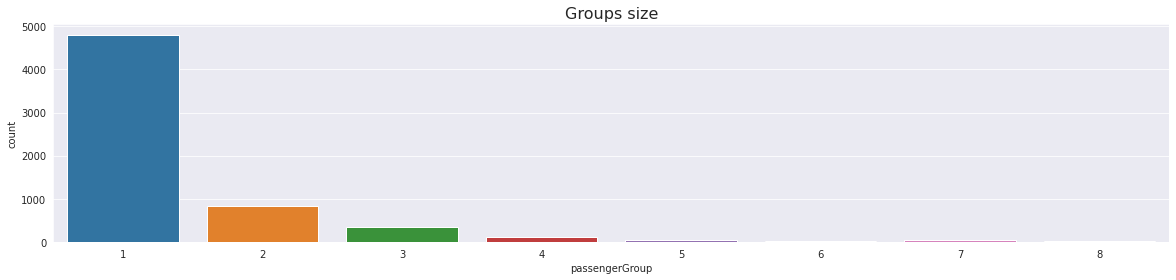

In [18]:
plt.figure(figsize=(20,4))
sns.countplot(spaceship.passengerGroup.value_counts()).set_title('Groups size', fontsize=16)

> **Most of passengers are alone, and very littls counts are groups from 2 to 8 persons**

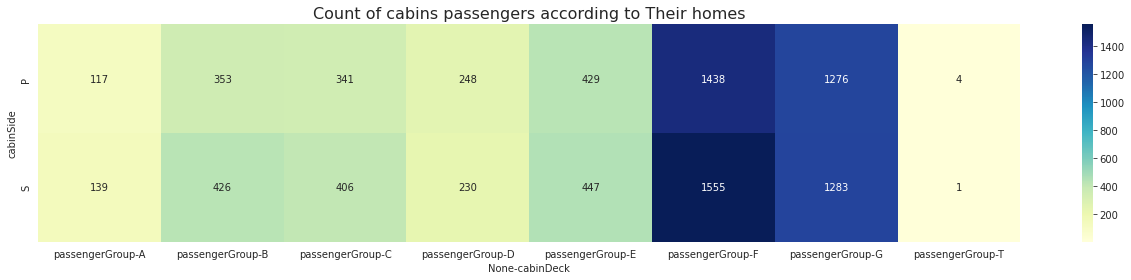

In [19]:
plt.figure(figsize=(22,4))
home_distination = pd.pivot_table(data=spaceship, columns=['cabinDeck'], index=['cabinSide'], values=['passengerGroup'], aggfunc='count')
sns.heatmap(home_distination,cmap='YlGnBu', annot=True, fmt='.4g').set_title('Count of cabins passengers according to Their homes', fontsize=16)
plt.show()

> **Passenger counts almost balanced between two sides of each cabin**

# Preprocessing

## Splitting data frame

In [20]:
spaceshipX = spaceship.drop(columns=['Transported'])
spaceshipY = spaceship['Transported']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
xtrain, xvalid, ytrain, yvalid = train_test_split(spaceshipX,spaceshipY, test_size=.3, random_state=20)

In [21]:
col_scale = ['Age','passengerGroup','cabinNum','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Service_val' ]
scaler1 = StandardScaler().fit(xtrain[col_scale])
xtrain[col_scale] = scaler1.transform(xtrain[col_scale])

encoder={}
col_encode = ['CryoSleep','VIP','cabinSide','Destination','HomePlanet','cabinDeck']
for col in col_encode:
    encoder[col] = LabelEncoder().fit(xtrain[col])

def encode_columns(df):
    for col in col_encode:
        df[col] = encoder[col].transform(df[col])
    return df

encode_columns(xtrain)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,passengerGroup,cabinDeck,cabinNum,cabinSide,Service_val,Service_count
7419,0,0,2,-0.004057,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,1.230938,6,1.349090,0,-0.523075,0
6265,1,0,2,-0.201027,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,0.744270,1,-0.677042,1,-0.523075,0
6234,0,0,2,-0.201027,0,-0.341088,0.130830,-0.286577,-0.280689,-0.218726,0.729330,5,1.518426,0,-0.269279,2
6442,1,0,2,1.470615,1,-0.341088,4.259582,-0.063710,-0.195494,0.101832,0.807018,1,-0.669165,1,2.269389,4
7032,2,1,1,1.122356,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,1.063611,4,-0.222196,0,-0.523075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,2,1,2,0.286535,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,0.607944,5,1.187629,1,-0.523075,0
3915,1,1,2,1.052704,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,-0.171546,2,-0.917263,0,-0.523075,0
7068,0,0,2,0.843749,0,-0.341088,-0.284102,-0.286577,-0.280689,0.494558,1.076310,6,1.211258,0,-0.204778,1
7391,0,0,2,2.167132,0,-0.341088,-0.284102,-0.286577,-0.280689,-0.267397,1.218239,6,1.333337,0,-0.523075,0


<AxesSubplot:>

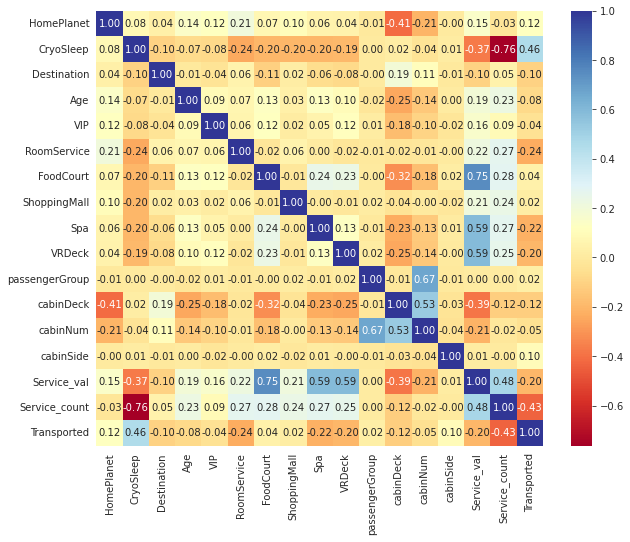

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,8))
sns.heatmap(pd.concat([xtrain, ytrain], axis=1).corr(), cmap="RdYlBu", annot=True, fmt=".02f")

> **Looks like there is no relation between transportation status and any other feature, maybe cryosleep and number of services and it's weak, otherwise all seems completely random**
>
> **Lets build the model**

## preparing the numeric data scaler and categorical data encoder

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Makeing Pipeline

In [24]:
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabinDeck','cabinSide']
num_cols1 = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
num_cols2 = ['Age','cabinNum']

pipeExtracting = Pipeline(steps=[('SplitGroupCabin', FunctionTransformer(SplitGroupCabin)), ('convert_types', FunctionTransformer(convert_types))])

categorical = Pipeline(steps=[('impute_mode', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),('label_encoder', OneHotEncoder())])

Numerical1 = Pipeline(steps=[('impute_zero', SimpleImputer(missing_values=np.nan, fill_value=0)), ('standard scaler',StandardScaler())])
Numerical2 = Pipeline(steps=[('impute_mean', SimpleImputer(missing_values=np.nan, strategy='mean')),(('standard scaler',StandardScaler()))])

transformer = ColumnTransformer(transformers=[('categorical',categorical,cat_cols),('Numerical1',Numerical1,num_cols1), ('Numerical2',Numerical2, num_cols2)])
                              
pipe = Pipeline([('pipeExtracting',pipeExtracting),('All Transformers', transformer), ('NLP model', MLPClassifier(activation='tanh'))])

##  Let's start againg with the original data

In [25]:
spaceship_trainX = spaceship_train.drop(columns='Transported')
spaceship_trainY = spaceship_train.Transported
xtrain, xvalid, ytrain, yvalid = train_test_split(spaceship_trainX,spaceship_trainY, test_size=.2, random_state=30)
pipe.fit(xtrain,ytrain)

Pipeline(steps=[('pipeExtracting',
                 Pipeline(steps=[('SplitGroupCabin',
                                  FunctionTransformer(func=<function SplitGroupCabin at 0x7fddc57c1560>)),
                                 ('convert_types',
                                  FunctionTransformer(func=<function convert_types at 0x7fddc545e950>))])),
                ('All Transformers',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most...
                                                   'cabinDeck', 'cabinSide']),
                                                 ('Numerical1',
                                                  Pipeline(steps=[('impute_zero',
                                                                   SimpleImputer(fill_value=0)),
                                                                  ('standard '
                                                                   'scaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck']),
                                                 ('Numerical2',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('standard '
                                                                   'scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'cabinNum'])])),
                ('NLP model', MLPClassifier(activation='tanh'))])

In [26]:
ypred = pipe.predict(xvalid)
ypred

array([False,  True,  True, ..., False, False,  True])

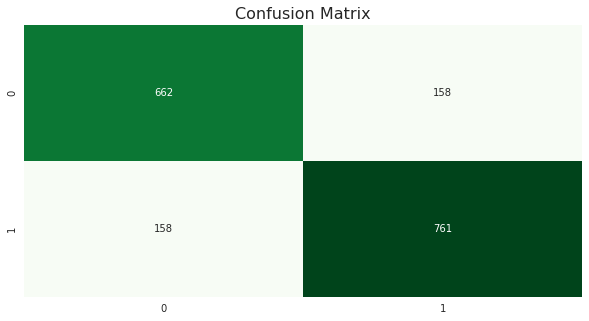

In [27]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(yvalid,ypred), annot=True, fmt='d', cmap='Greens',cbar=False).set_title('Confusion Matrix', fontsize=16)
plt.show()

In [28]:
print('Confusion Matrix'.center(70,'-'), '\n')
print(confusion_matrix(yvalid,ypred), '\n')
print('Classification Report'.center(70,'-'), '\n')
print(classification_report(yvalid,ypred))
print('Score'.center(70,'-'), '\n')
print (f'Score of Model NLP is  {round(accuracy_score(yvalid, ypred) * 100,2)}%')

---------------------------Confusion Matrix--------------------------- 

[[662 158]
 [158 761]] 

------------------------Classification Report------------------------- 

              precision    recall  f1-score   support

       False       0.81      0.81      0.81       820
        True       0.83      0.83      0.83       919

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

--------------------------------Score--------------------------------- 

Score of Model NLP is  81.83%


# Submission

In [29]:
idx = pd.Index(spaceship_test.PassengerId)
ytest = pipe.predict(spaceship_test)
submit = pd.Series(data = ytest, index = idx, name = 'Transported')
submit

PassengerId
0013_01     True
0018_01    False
0019_01     True
0021_01     True
0023_01     True
           ...  
9266_02     True
9269_01    False
9271_01     True
9273_01     True
9277_01    False
Name: Transported, Length: 4277, dtype: bool

In [30]:
submit.to_csv('submission.csv')

## I'd Love to hear any comment about this notebook, and i'll be thankful if Upvoted